# Kernel ridge regression

This example illustrates the kernel ridge regression.

Kernel ridge regression uses a
so-called "kernel trick" to make their models expressive enough to fit
the training data.

Kernel ridge regression will find the target function that minimizes a loss
function (the mean squared error).

## Generating a dataset

We create a synthetic dataset. The true generative process will take a 1-D vector and compute its sine. Note that the period of this sine is thus $2 \pi$. We will reuse this information later in this example.

In [3]:
import numpy as np

rng = np.random.RandomState(0)
data = np.linspace(0, 30, num=1_000).reshape(-1, 1)
target = np.sin(data).ravel()

Now, we can imagine a scenario where we get observations from this true
process. However, we will add some challenges:

- the measurements will be noisy;
- only samples from the beginning of the signal will be available.

In [4]:
training_sample_indices = rng.choice(np.arange(0, 400), size=40, replace=False)
training_data = data[training_sample_indices]
training_noisy_target = target[training_sample_indices] + 0.5 * rng.randn(
    len(training_sample_indices)
)

Let’s plot the true signal and the noisy measurements available for training.

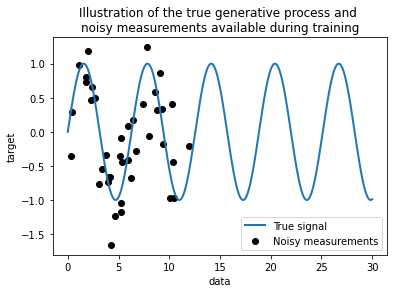

In [5]:
import matplotlib.pyplot as plt

plt.plot(data, target, label="True signal", linewidth=2)
plt.scatter(
    training_data,
    training_noisy_target,
    color="black",
    label="Noisy measurements",
)
plt.legend()
plt.xlabel("data")
plt.ylabel("target")
_ = plt.title(
    "Illustration of the true generative process and \n"
    "noisy measurements available during training"
)

## Limitations of a simple linear model

First, we would like to highlight the limitations of a linear model given
our dataset. We fit a :class:`~sklearn.linear_model.Ridge` and check the
predictions of this model on our dataset.

First, we would like to highlight the limitations of a linear model given our dataset. We fit a Ridge and check the predictions of this model on our dataset.

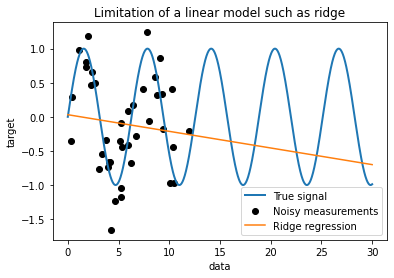

In [6]:
from sklearn.linear_model import Ridge

ridge = Ridge().fit(training_data, training_noisy_target)

plt.plot(data, target, label="True signal", linewidth=2)
plt.scatter(
    training_data,
    training_noisy_target,
    color="black",
    label="Noisy measurements",
)
plt.plot(data, ridge.predict(data), label="Ridge regression")
plt.legend()
plt.xlabel("data")
plt.ylabel("target")
_ = plt.title("Limitation of a linear model such as ridge")

Such a ridge regressor underfits data since it is not expressive enough.

### Kernel ridge

We can make the previous linear model more expressive by using a so-called
kernel. A kernel is an embedding from the original feature space to another
one. Simply put, it is used to map our original data into a newer and more
complex feature space. This new space is explicitly defined by the choice of
kernel.

We can use a :class:`~sklearn.gaussian_process.kernels.RBF` kernel which we saw during the course. The class
:class:`~sklearn.kernel_ridge.KernelRidge` will accept such a kernel.

Using this model together with a kernel is equivalent to embed the data
using the mapping function of the kernel and then apply a ridge regression.
In practice, the data are not mapped explicitly; instead the dot product
between samples in the higher dimensional feature space is computed using the
"kernel trick".

Thus, let's use such a :class:`~sklearn.kernel_ridge.KernelRidge`.

In [8]:
import time
from sklearn.gaussian_process.kernels import ExpSineSquared
from sklearn.kernel_ridge import KernelRidge

kernel_ridge = KernelRidge(kernel=ExpSineSquared())

start_time = time.time()
kernel_ridge.fit(training_data, training_noisy_target)
print(
    f"Fitting KernelRidge with default kernel: {time.time() - start_time:.3f} seconds"
)

Fitting KernelRidge with default kernel: 0.001 seconds


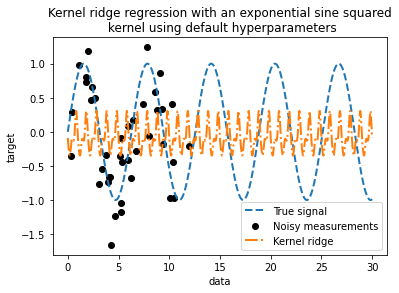

In [9]:
plt.plot(data, target, label="True signal", linewidth=2, linestyle="dashed")
plt.scatter(
    training_data,
    training_noisy_target,
    color="black",
    label="Noisy measurements",
)
plt.plot(
    data,
    kernel_ridge.predict(data),
    label="Kernel ridge",
    linewidth=2,
    linestyle="dashdot",
)
plt.legend(loc="lower right")
plt.xlabel("data")
plt.ylabel("target")
_ = plt.title(
    "Kernel ridge regression with an exponential sine squared\n "
    "kernel using default hyperparameters"
)

This fitted model is not accurate. Indeed, we did not set the parameters of the kernel and instead used the default ones. We can inspect them.

In [10]:
kernel_ridge.kernel

ExpSineSquared(length_scale=1, periodicity=1)

Our kernel has two parameters: the length-scale and the periodicity. For our dataset, we use sin as the generative process, implying a $2\pi$-periodicity for the signal. The default value of the parameter being $1$, it explains the high frequency observed in the predictions of our model. Similar conclusions could be drawn with the length-scale parameter. Thus, it tell us that the kernel parameters need to be tuned. We will use a randomized search to tune the different parameters the kernel ridge model: the alpha parameter and the kernel parameters.

In [11]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.fixes import loguniform

param_distributions = {
    "alpha": loguniform(1e0, 1e3),
    "kernel__length_scale": loguniform(1e-2, 1e2),
    "kernel__periodicity": loguniform(1e0, 1e1),
}
kernel_ridge_tuned = RandomizedSearchCV(
    kernel_ridge,
    param_distributions=param_distributions,
    n_iter=500,
    random_state=0,
)
start_time = time.time()
kernel_ridge_tuned.fit(training_data, training_noisy_target)
print(f"Time for KernelRidge fitting: {time.time() - start_time:.3f} seconds")

Time for KernelRidge fitting: 2.776 seconds


Fitting the model is now more computationally expensive since we have to try several combinations of hyperparameters. We can have a look at the hyperparameters found to get some intuitions.

In [12]:
kernel_ridge_tuned.best_params_

{'alpha': 1.9915849773450223,
 'kernel__length_scale': 0.7986499491396728,
 'kernel__periodicity': 6.607275806426108}

Looking at the best parameters, we see that they are different from the defaults. We also see that the periodicity is closer to the expected value: $2\pi$. We can now inspect the predictions of our tuned kernel ridge.

In [13]:
start_time = time.time()
predictions_kr = kernel_ridge_tuned.predict(data)
print(f"Time for KernelRidge predict: {time.time() - start_time:.3f} seconds")

Time for KernelRidge predict: 0.016 seconds


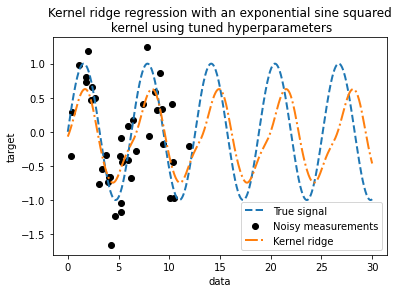

In [14]:
plt.plot(data, target, label="True signal", linewidth=2, linestyle="dashed")
plt.scatter(
    training_data,
    training_noisy_target,
    color="black",
    label="Noisy measurements",
)
plt.plot(
    data,
    predictions_kr,
    label="Kernel ridge",
    linewidth=2,
    linestyle="dashdot",
)
plt.legend(loc="lower right")
plt.xlabel("data")
plt.ylabel("target")
_ = plt.title(
    "Kernel ridge regression with an exponential sine squared\n "
    "kernel using tuned hyperparameters"
)

We get a much more accurate model. We still observe some errors mainly due to the noise added to the dataset.